# makemore_BatchNorm

----
* Inspired by Andrej Karpathy's ["Building makemore Part 3: Activations & Gradients, BatchNorm
"](https://www.youtube.com/watch?v=P6sfmUTpUmc)

* Useful links 
    - ["Kaiming init" paper](https://arxiv.org/abs/1502.01852)
    - [BatchNorm paper](https://arxiv.org/abs/1502.03167)
    - Bengio et al. 2003 MLP language model paper [(pdf)](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)
    - Good [paper](https://arxiv.org/abs/2105.07576) illustrating some of the problems with batchnorm in practice

-----
<br><br>
# Exercises
----

1. I did not get around to seeing what happens when you [initialize all weights and biases to zero.](#1) Try this and train the neural net. You might think either that 
* the network trains just fine or 
* the network doesn't train at all, but actually it is 
* the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.
2. `BatchNorm`, unlike other normalization layers like `LayerNorm`/`GroupNorm` etc. has the big advantage that after training, the `batchnorm` `gamma`/`beta` can be "folded into" the weights of the preceding linear layers, effectively erasing the need to forward it at test time. 
    - Set up a [small 3-layer MLP with `batchnorms`](#2), 
    - train the network, 
    - then ["fold"](#202) the `batchnorm` `gamma`/`beta` into the preceding linear layer's `W`, `b` by creating a new `W2`, `b2` and erasing the batch norm. 
    - Verify that this gives the same forward pass during inference. i.e. we see that the `batchnorm` is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.
    
----

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('../data/names.txt', 'r').read().splitlines()
print(words[:8])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033


In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
block_size = 3 

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] 

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


-----
<a id="1"></a>
# 1. Initialize all weights and biases to $0$
----
## gamma = bn_gain, beta = bn_bias

In [76]:
gain = 5/3
last_layer_scale_factor = 0.1

batch_norm = False
#fan_in_norm = False

In [77]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        if batch_norm:
            self.weight = torch.zeros((fan_in, fan_out))
        if not batch_norm:
            self.weight = torch.zeros((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        
        # update the buffers in training
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [78]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)

if batch_norm:
    layers = [
      Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
      Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
      Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
      Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
      Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
      Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
    ]
if not batch_norm:
    layers = [
      Linear(n_embd * block_size, n_hidden), Tanh(),
      Linear(           n_hidden, n_hidden), Tanh(),
      Linear(           n_hidden, n_hidden), Tanh(),
      Linear(           n_hidden, n_hidden), Tanh(),
      Linear(           n_hidden, n_hidden), Tanh(),
      Linear(           n_hidden, vocab_size),
    ]

with torch.no_grad():
    # last layer: make less confident
    if batch_norm:
        layers[-1].gamma *= last_layer_scale_factor
    if not batch_norm:
        layers[-1].weight *= last_layer_scale_factor
        
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= gain   # default value: 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True
    

46497


In [162]:
# same optimization as last time


def train_model(Xtr, Ytr, C, layers, parameters, 
                max_steps = 200000, batch_size = 32, learn_rate=0.1):
    lossi = []
    ud = []    # update_to_date_ratio

    for i in range(max_steps):

        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

        # forward pass
        emb = C[Xb] # embed the characters into vectors
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        loss = F.cross_entropy(x, Yb) # loss function

        # backward pass
        for layer in layers:
            layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        lr = learn_rate if i < (0.75 * max_steps) else 0.1 * learn_rate  # step learning rate decay
        for p in parameters:
            p.data += -lr * p.grad

        # track stats
        if i % (max_steps/20) == 0: # print every once in a while (lr = 20000)
        #if i % (max_steps/10) == 0: # (lr = 100000)
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

        lossi.append(loss.log10().item())

        with torch.no_grad():
            ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    print(f"training loss: {loss.item()}")
    return lossi, ud, layers, parameters, x

In [172]:
def plot_forward_activations(layers):
    plt.figure(figsize=(12, 4)) # width and height of the plot
    legends = []
    for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
        if isinstance(layer, Tanh):
            t = layer.out
            print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'layer {i} ({layer.__class__.__name__})')
    plt.legend(legends)
    plt.title('activation distribution')


def plot_backward_gradients(layers):
    plt.figure(figsize=(12, 4)) # width and height of the plot
    legends = []
    for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
        if isinstance(layer, Tanh):
            t = layer.out.grad
            print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'layer {i} ({layer.__class__.__name__})')
        plt.legend(legends);
    plt.title('gradient distribution')


def plot_weights_gradients(parameters):
    plt.figure(figsize=(12, 4)) # width and height of the plot
    legends = []
    for i,p in enumerate(parameters):
        t = p.grad
        if p.ndim == 2:
            print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'{i} {tuple(p.shape)}')
    plt.legend(legends)
    plt.title('weights gradient distribution')

    
def plot_weights_last_layer(parameters):
    plt.figure(figsize=(12, 4))
    legends = []

    for i,p in enumerate(parameters):
        t = p.grad

        # neglect bias and batch norm parameters (weights only)
        if p.ndim == 2:
            print(f"weight shape {tuple(p.shape)} | mean {t.mean().item():.5f} | std {t.std().item():.5f} | grad:data ratio {t.std() / p.std():.2e}")
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f"weight {i} ({p.shape})")
            
        if i == len(parameters) - 1:
            print(f"last layer weight shape {tuple(p.shape)} | mean {t.mean().item():.5f} | std {t.std().item():.5f} | grad:data ratio {t.std() / p.std():.2e}")
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f"last layer: weight {i} ({p.shape})")
    plt.legend(legends)
    plt.title("Weights Gradient distribution")
    
    
def plot_update_to_data_ratio(parameters, ud):
    plt.figure(figsize=(12, 4))
    legends = []
    for i,p in enumerate(parameters):
        if p.ndim == 2:
            plt.plot([ud[j][i] for j in range(len(ud))])
            legends.append('param %d' % i)
    plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
    plt.legend(legends)
    plt.title('update-to-data ratio over time')

In [81]:
zero_W_b_losses, zero_W_b_updates, zero_W_b_layers, zero_W_b_parameters, zero_W_b_logits = \
train_model(Xtr, Ytr, C, layers, parameters, max_steps = 20000, 
            batch_size = 32, learn_rate=0.1)

      0/  20000: 3.2958
   1000/  20000: 2.7689
   2000/  20000: 2.6577
   3000/  20000: 2.8419
   4000/  20000: 2.8023
   5000/  20000: 2.8188
   6000/  20000: 2.8556
   7000/  20000: 2.7194
   8000/  20000: 2.7612
   9000/  20000: 2.7593
  10000/  20000: 2.7882
  11000/  20000: 2.7591
  12000/  20000: 2.7606
  13000/  20000: 2.8545
  14000/  20000: 2.8490
  15000/  20000: 2.9410
  16000/  20000: 2.9307
  17000/  20000: 2.7226
  18000/  20000: 2.8905
  19000/  20000: 2.9722
training loss: 2.6480002403259277


layer 1 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 3 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 7 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 9 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


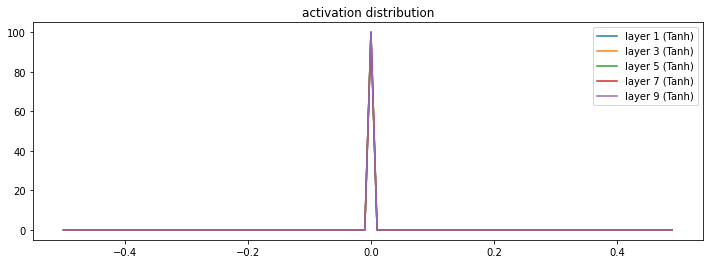

In [82]:
plot_forward_activations(zero_W_b_layers)

layer 1 (      Tanh): mean +0.000000, std 0.000000e+00
layer 3 (      Tanh): mean +0.000000, std 0.000000e+00
layer 5 (      Tanh): mean +0.000000, std 0.000000e+00
layer 7 (      Tanh): mean +0.000000, std 0.000000e+00
layer 9 (      Tanh): mean +0.000000, std 0.000000e+00


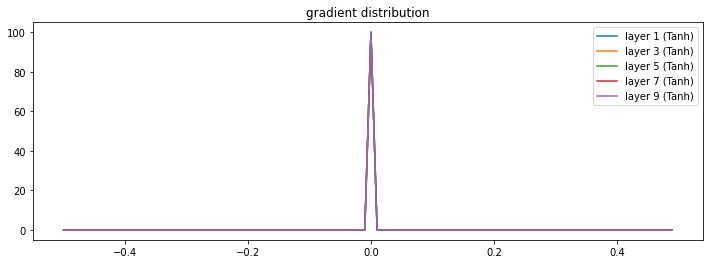

In [83]:
plot_backward_gradients(zero_W_b_layers)

weight   (27, 10) | mean +0.000000 | std 0.000000e+00 | grad:data ratio 0.000000e+00
weight  (30, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight  (100, 27) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan


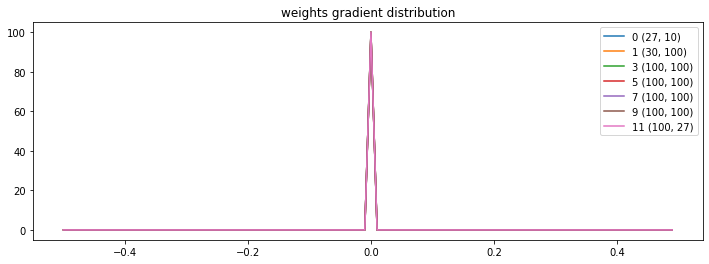

In [84]:
plot_weights_gradients(zero_W_b_parameters)

weight shape (27, 10) | mean 0.00000 | std 0.00000 | grad:data ratio 0.00e+00
weight shape (30, 100) | mean 0.00000 | std 0.00000 | grad:data ratio nan
weight shape (100, 100) | mean 0.00000 | std 0.00000 | grad:data ratio nan
weight shape (100, 100) | mean 0.00000 | std 0.00000 | grad:data ratio nan
weight shape (100, 100) | mean 0.00000 | std 0.00000 | grad:data ratio nan
weight shape (100, 100) | mean 0.00000 | std 0.00000 | grad:data ratio nan
weight shape (100, 27) | mean 0.00000 | std 0.00000 | grad:data ratio nan
last layer weight shape (27,) | mean 0.00000 | std 0.04007 | grad:data ratio 3.31e-02


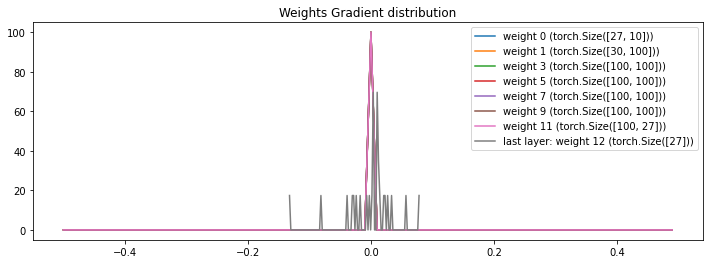

In [173]:
plot_weights_last_layer(zero_W_b_parameters)

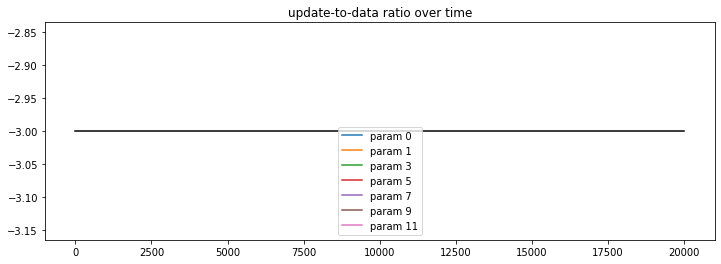

In [85]:
plot_update_to_data_ratio(zero_W_b_parameters, zero_W_b_updates)

----

**Comment:** The nonlinearity saturation is $\boldsymbol{0\%}$ which indicates that the layers are not learning/training. This is further supported by the gradients distribution being shrunk down to $\boldsymbol0$. It seems like the model is not learning/training at all but from the weights last layer plot we see that the last layer's bias has learned even though the weights are still $\boldsymbol{0}$. Overall the model isn't learning as evidenced in the update ratio plot.

----

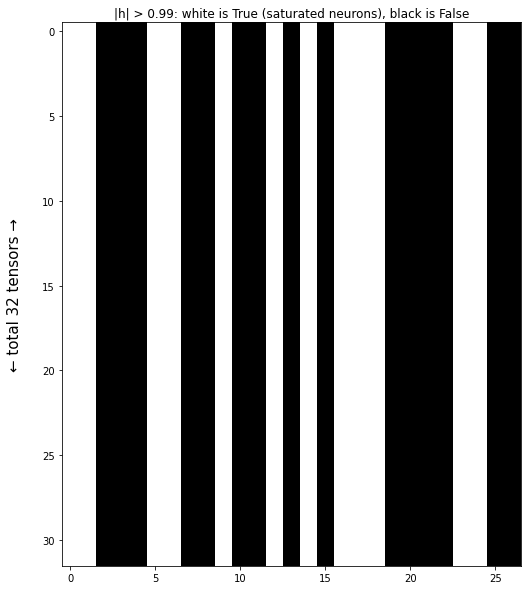

In [131]:
plt.figure(figsize=(20,10))
plt.imshow(zero_W_b_logits.abs() > 0.97, cmap = 'gray', interpolation = 'nearest')
plt.title("|h| > 0.99: white is True (saturated neurons), black is False")
plt.ylabel("← total 32 tensors →", labelpad=20, fontdict={"size":15});

In [246]:
for layer in zero_W_b_layers:
    print(layer.__class__.__name__)

Linear
Tanh
Linear
Tanh
Linear
Tanh
Linear
Tanh
Linear
Tanh
Linear


In [247]:
count = 0
for layer in zero_W_b_layers:
    for param in layer.parameters():
        #print(param.grad)
        if param.grad.sum() > 0.0:
            print(layer.__class__.__name__)
            print(f"non zero grad: {param.grad}")
            print()
            print(f"param index of non zero grad: {count} / {len(zero_W_b_layers)}")
        count += 1   

Linear
non zero grad: tensor([-0.0162, -0.1324,  0.0117,  0.0151,  0.0248,  0.0570,  0.0039, -0.0230,
         0.0342, -0.0797,  0.0126,  0.0223, -0.0018,  0.0289,  0.0804,  0.0047,
         0.0046, -0.0299, -0.0375, -0.0272, -0.0064,  0.0141,  0.0110,  0.0041,
         0.0030,  0.0112,  0.0107])

param index of non zero grad: 11 / 11


-----
<a id="2"></a>
# 2.  MLP3 (3-Layer MLP)
----

In [250]:
gain = 1
last_layer_scale_factor = 0.1

batch_norm = True
#fan_in_norm = False

In [251]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        if batch_norm:
            self.weight = torch.randn((fan_in, fan_out), generator=g)
        if not batch_norm:
            self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        
        # update the buffers in training
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [252]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)

if batch_norm:
    layers = [
      Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
      Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
      Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
    ]
if not batch_norm:
    layers = [
      Linear(n_embd * block_size, n_hidden), Tanh(),
      Linear(           n_hidden, n_hidden), Tanh(),
      Linear(           n_hidden, n_hidden), Tanh(),
      Linear(           n_hidden, n_hidden), Tanh(),
      Linear(           n_hidden, n_hidden), Tanh(),
      Linear(           n_hidden, vocab_size),
    ]

with torch.no_grad():
    # last layer: make less confident
    if batch_norm:
        layers[-1].gamma *= last_layer_scale_factor
    if not batch_norm:
        layers[-1].weight *= last_layer_scale_factor
        
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= gain   # default value: 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True
    

16424


In [253]:
# same optimization as last time


def train_model_no_lr_decay(Xtr, Ytr, C, layers, parameters, 
                max_steps = 200000, batch_size = 32, learn_rate=0.1):
    lossi = []
    ud = []    # update_to_date_ratio

    for i in range(max_steps):

        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

        # forward pass
        emb = C[Xb] # embed the characters into vectors
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        loss = F.cross_entropy(x, Yb) # loss function

        # backward pass
        for layer in layers:
            layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        lr = learn_rate #learn_rate if i < (0.75 * max_steps) else 0.1 * learn_rate  # step learning rate decay
        for p in parameters:
            p.data += -lr * p.grad

        # track stats
        #if i % (max_steps/20) == 0: # print every once in a while (lr = 20000)
        if i % (max_steps/10) == 0: # (lr = 100000)
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

        lossi.append(loss.log10().item())

        with torch.no_grad():
            ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    print(f"training loss: {loss.item()}")
    return lossi, ud, layers, parameters, x

In [254]:
MLP3_losses, MLP3_updates, MLP3_layers, MLP3_parameters, MLP3_logits = \
train_model(Xtr, Ytr, C, layers, parameters, max_steps = 100000, 
            batch_size = 32, learn_rate=0.1)

      0/ 100000: 3.3138
  10000/ 100000: 2.8430
  20000/ 100000: 2.5132
  30000/ 100000: 2.2348
  40000/ 100000: 2.3918
  50000/ 100000: 2.1464
  60000/ 100000: 1.8751
  70000/ 100000: 2.1717
  80000/ 100000: 2.5002
  90000/ 100000: 1.9719
training loss: 2.3254995346069336


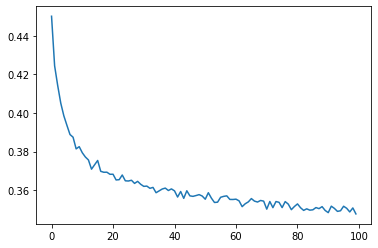

In [255]:
plt.plot(torch.tensor(MLP3_losses).view(-1, 1000).mean(1));

layer 2 (      Tanh): mean -0.06, std 0.68, saturated: 9.03%
layer 5 (      Tanh): mean +0.03, std 0.68, saturated: 9.47%


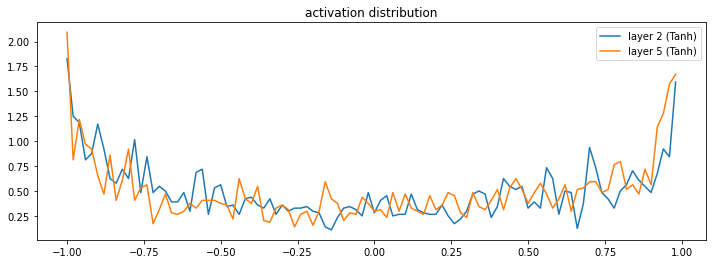

In [256]:
plot_forward_activations(MLP3_layers)

layer 2 (      Tanh): mean +0.000000, std 6.916019e-03
layer 5 (      Tanh): mean +0.000000, std 5.717656e-03


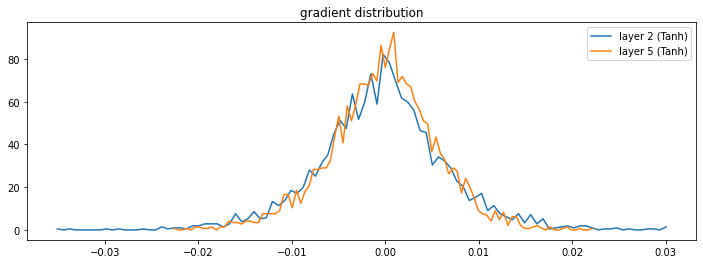

In [257]:
plot_backward_gradients(MLP3_layers)

weight   (27, 10) | mean -0.000000 | std 1.541226e-02 | grad:data ratio 1.445028e-02
weight  (30, 100) | mean -0.000088 | std 4.815627e-03 | grad:data ratio 4.661902e-03
weight (100, 100) | mean +0.000007 | std 2.178752e-03 | grad:data ratio 2.181285e-03
weight  (100, 27) | mean +0.000041 | std 3.628002e-03 | grad:data ratio 3.524541e-03


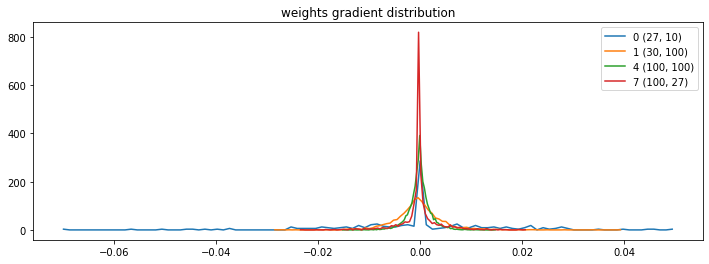

In [258]:
plot_weights_gradients(MLP3_parameters)

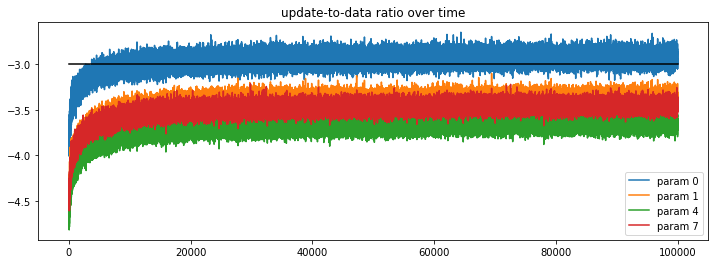

In [259]:
plot_update_to_data_ratio(MLP3_parameters, MLP3_updates)

**Comment:** The nonlinearity forward activations plot shows stabilization between the `Linear` and `Tanh` layers as we go deeper in the layers. We get a good low saturation percentage of $\boldsymbol{\sim8\%}$ (saturation is not $0$ or too high) with a small standard deviation range of $0.66 - 0.67$ across the entire network, which supports model homogeneity/stability once again.

The gradient distribution is fairly reasonable. All the different layers have roughly the same distribution. Things are not shrinking or exploding, and appear stable.

The weights gradients distribution look symmetric, and aligned for most of the layers. The gradient-to-data ratio seems to average around $2$E-$3$, which matches up approximately with the update ratio plots' black line at $-3$ from $\log{10^{-3}}$. However, we might need to increase our learning rate since the update ratio changes from $-3$ to roughly $-4$ around iteration step of $75000$ which is below the black line. Upon further inspection, switching off the learning rate decay might fix this.

**Comment:** We can view the loss across batches of 1000 and take the mean for every batch. The loss decreases as iterations increases which is good!

In [260]:
MLP3_no_lr_decay_vars = train_model_no_lr_decay(Xtr, Ytr, C, layers, parameters, max_steps = 100000, 
            batch_size = 32, learn_rate=0.1)

      0/ 100000: 2.2093
  10000/ 100000: 2.0916
  20000/ 100000: 2.5582
  30000/ 100000: 1.9778
  40000/ 100000: 1.9828
  50000/ 100000: 2.1729
  60000/ 100000: 2.2504
  70000/ 100000: 1.9624
  80000/ 100000: 2.4519
  90000/ 100000: 2.2894
training loss: 2.1088192462921143


In [261]:
type(MLP3_no_lr_decay_vars)

tuple

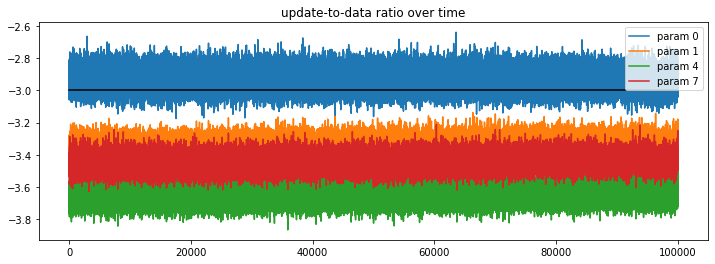

In [262]:
# MLP3_no_lr_decay_vars = (lossi, ud, layers, parameters, x)
no_decay_params = MLP3_no_lr_decay_vars[3]
no_decay_updates = MLP3_no_lr_decay_vars[1]
plot_update_to_data_ratio(no_decay_params, no_decay_updates)

**Comment:** As anticipidated, the learning rate decay was not needed. We now have a uniform update ratio dsitribution that lies on the black line which we want.

---
<a id="201"></a>
## 2.1.  Testing: With BatchNorm

---

In [263]:
# MLP3_no_lr_decay_vars = (lossi, ud, layers, parameters, x)
no_decay_layers = MLP3_no_lr_decay_vars[2]
no_decay_logits = MLP3_no_lr_decay_vars[4]

In [264]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "dev": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    
    emb = C[x] # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    for layer in no_decay_layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    
    print(f"{split} loss: {loss.item()}")

# put layers into eval mode
for layer in no_decay_layers:
    layer.training = False
split_loss('train')
split_loss('dev')
split_loss('test')

train loss: 2.1539957523345947
dev loss: 2.17282772064209
test loss: 2.1736271381378174


---
<a id="202"></a>
## 2.2.  Testing: Fold BatchNorm (`gamma`, `beta`) into Preceding Linear Layer (`W`, `b`)
---

BatchNorm can be folded into the preceding linear layer because its scaling and shifting operations can be absorbed into the weights and biases of the linear layer. Specifically, the **scaling factor (`gamma`) can be multiplied with the weights**, and the **shifting factor (`beta`) can be added to the biases**, effectively eliminating the need for a separate BatchNorm layer. This is possible because the `BatchNorm` layer only performs a ***linear transformation, which can be combined with the linear transformation of the preceding layer.*** By folding BatchNorm into the linear layer, we can simplify the network architecture and reduce computational overhead during inference.
It consists of two steps:

    1- normalizing the batch by subtracting its mean and dividing it by its standard deviation.
    2- scaling and shifting it by two learnable parameters called gamma and beta.

However, at inference time, BatchNorm is **not necessary** and can be removed to speed up the network.

One way to remove BatchNorm is to fold it into the preceding linear layer, which is also a `linear transformation`.

This means that we can combine the `weights` and `biases` of the **linear** **layer** with the `gamma` and `beta` of the **BatchNorm layer** to get a new linear layer that has the same output as the original one.

Rearrangement of the:

$$
y = \text{Linear}(x) = Wx + b
$$

$$
z = \text{BatchNorm}(y) = \gamma \frac{y - \mu}{\sigma} + \beta
$$

$$
z = \text{BatchNorm}(\text{Linear}(x)) = \gamma \frac{Wx + b - \mu}{\sigma} + \beta
$$

$$
z = (\frac{\gamma}{\sigma})Wx + (\frac{\gamma}{\sigma})(b - \mu) + \beta
$$

$$
z = W_2 x + b_2
$$

where $$W_2 = (\frac{\gamma}{\sigma})W, \quad b_2 = (\frac{\gamma}{\sigma})(b - \mu) + \beta$$


In [265]:
for layer in no_decay_layers:
    print(layer.__class__.__name__)

Linear
BatchNorm1d
Tanh
Linear
BatchNorm1d
Tanh
Linear
BatchNorm1d


Let's combine the parameters for layers $0$ and $1$, $3$ and $4$, & $6$ and $7$. Updating the `Linear` layers parameters (`W` and `b`) leveraging linear transformation will get the job done. We also will disable gradient checking. In essence we go from 8 layers with some as `BatchNorm1d` to 5 layers with no `BatchNorm1d` layer.

In [266]:
with torch.no_grad():
    layers[0].weight *= (layers[1].gamma / torch.sqrt(layers[1].running_var))
    layers[3].weight *= (layers[4].gamma / torch.sqrt(layers[4].running_var))
    layers[6].weight *= (layers[7].gamma / torch.sqrt(layers[7].running_var))
    layers[0].bias = - ((layers[1].gamma * layers[1].running_mean) / torch.sqrt(layers[1].running_var)) + layers[1].beta
    layers[3].bias = - ((layers[4].gamma * layers[4].running_mean) / torch.sqrt(layers[4].running_var)) + layers[4].beta
    layers[6].bias = - ((layers[7].gamma * layers[7].running_mean) / torch.sqrt(layers[7].running_var)) + layers[7].beta
     

In [267]:
new_layers = []

for layer in layers:
    if not isinstance(layer, BatchNorm1d):
        new_layers.append(layer)

for layer in new_layers:
    print(layer.__class__.__name__)

Linear
Tanh
Linear
Tanh
Linear


In [268]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "dev": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    
    emb = C[x] # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    for new_layer in new_layers:
        x = new_layer(x)
    loss = F.cross_entropy(x, y)
    
    print(f"{split} loss: {loss.item()}")

# put layers into eval mode
for layer in new_layers:
    layer.training = False
split_loss('train')
split_loss('dev')  
split_loss('test')

train loss: 2.1539957523345947
dev loss: 2.17282772064209
test loss: 2.1736271381378174


**Comment:** The losses for both cases (batchNorm, no batchNorm) are the same !!!

## ASIDE: Pythonic checks

In [269]:
_a_tests22 = True

In [270]:
if _a_tests22:
    print("batchnorm YAY")
    case = 'batch'
if not _a_tests22:
    print("no batchnorm :((((((")
    case = 'no batch'
    
case

batchnorm YAY


'batch'

In [271]:
def _B_fn(case):
    return case

In [272]:
_B_fn(case)

'batch'

In [273]:
alpha = 100000
for i in range(alpha):
    if i % (alpha/10) == 0:
        print(i)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
